# STECR-F

In [29]:
import numpy as np
import rasterio
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.plot import show
from scipy.ndimage import convolve
import os 
from sklearn.model_selection import ParameterGrid
import time

class STECR_F:
    """
    This class is used for processing interannual tree species classification, including:
    - Loading images
    - Converting to one-hot encoding
    - Calculating spatiotemporal entropy
    - Applying weighted convolution
    - Post-processing classification results
    """
    
    def __init__(self, img2019_path, img2020_path, img2021_path, output_dir):
        """
        Initialize the class object and load image data

        :param img2019_path: Path to 2019 classification image
        :param img2020_path: Path to 2020 classification image
        :param img2021_path: Path to 2021 classification image
        :param output_dir: Output directory path
        """
        self.img2019, self.transform2019 = self.load_image(img2019_path)
        self.img2020, self.transform2020 = self.load_image(img2020_path)
        self.img2021, self.transform2021 = self.load_image(img2021_path)
        self.output_dir = output_dir  # Output directory

    def load_image(self, file_path):
        """
        Load a raster image and return the image data and its transform information

        :param file_path: Path to the image file
        :return: Image data and transform information
        """
        with rasterio.open(file_path) as src:
            img = src.read(1)  # Read the first band
            transform = src.transform  # Get the transform information
        return img, transform

    def to_one_hot(self, image, num_classes):
        """
        Convert image data to one-hot encoding format

        :param image: Input classification image
        :param num_classes: Number of classes
        :return: One-hot encoded image
        """
        one_hot = np.zeros((image.shape[0], image.shape[1], num_classes), dtype=np.uint8)
        for class_num in range(num_classes):
            one_hot[:, :, class_num] = (image == class_num).astype(np.uint8) * (image != -1)
        return one_hot

    def create_weights(self, center_weight, constant_weight):
        """
        Create a weighted matrix

        :param center_weight: Weight of the center point
        :param constant_weight: Constant weight for surrounding points
        :return: Weighted matrix
        """
        weights = np.array([[constant_weight, constant_weight, constant_weight],
                            [constant_weight, center_weight, constant_weight],
                            [constant_weight, constant_weight, constant_weight]])
        return weights

    def calculate_STE(self, one_hot_images, neighborhood_size):
        """
        Calculate spatiotemporal entropy based on the class distribution of each pixel

        :param one_hot_images: List of one-hot encoded images
        :param neighborhood_size: Neighborhood size for convolution
        :return: Entropy image
        """
        rows, cols, num_classes = one_hot_images[0].shape
        kernel = np.ones((neighborhood_size, neighborhood_size))  # Create neighborhood convolution kernel
        entropy_image = np.zeros((rows, cols), dtype=float)
        all_counts = np.zeros((rows, cols, num_classes), dtype=float)  # Store counts for each class

        # Calculate neighborhood counts for each class
        for k in range(len(one_hot_images)):
            one_hot_image = one_hot_images[k]
            for c in range(num_classes):
                category_image = one_hot_image[:, :, c]
                counts = convolve(category_image, kernel, mode='constant', cval=0)
                all_counts[:, :, c] += counts

        total_counts = all_counts.sum(axis=2)  # Calculate total counts
        non_zero_mask = total_counts > 0  # Filter invalid pixels

        # Calculate entropy
        probabilities = np.divide(all_counts, total_counts[..., np.newaxis], where=non_zero_mask[..., np.newaxis])
        entropy_image[non_zero_mask] = -np.sum(probabilities * np.log(probabilities + 1e-10), axis=2)[non_zero_mask]
        entropy_image[~non_zero_mask] = -1  # Set pixels with no valid classification to -1

        return entropy_image

    def apply_weighted_convolution(self, weights_list, one_hot2019, one_hot2020, one_hot2021):
        """
        Apply weighted convolution to the images

        :param weights_list: List of weights for each year
        :param one_hot2019: One-hot encoded 2019 image
        :param one_hot2020: One-hot encoded 2020 image
        :param one_hot2021: One-hot encoded 2021 image
        :return: Weighted sum after convolution
        """
        weighted_sum = np.zeros_like(one_hot2020, dtype=float)
        
        # Loop through each weight and apply convolution
        for k in range(len(weights_list)):
            weights = np.array(weights_list[k])
            one_hot_image = [one_hot2019, one_hot2020, one_hot2021][k]

            for i in range(one_hot_image.shape[2]):  # Convolve for each class
                weighted_sum[:, :, i] += convolve(one_hot_image[:, :, i], weights, mode='constant', cval=0)
        
        return weighted_sum

    def process_tree_species_classification(self, weights_list, entropy_threshold, output_file_path, validate_data_path=None):
        """
        Process the tree species classification results for post-processing

        :param weights_list: List of weights for each year
        :param entropy_threshold: Threshold for entropy value
        :param output_file_path: Output file path for processed result
        :param validate_data_path: Path to validation data (optional)
        :return: Processed entropy image
        """
        

        # Record the time taken for calculate_STE
        start_time_entropy = time.time()
        
        # Convert images to one-hot encoding
        one_hot2019 = self.to_one_hot(self.img2019, num_classes=7)
        one_hot2020 = self.to_one_hot(self.img2020, num_classes=7)
        one_hot2021 = self.to_one_hot(self.img2021, num_classes=7)

        # Calculate entropy image
        entropy_img = self.calculate_STE([one_hot2019, one_hot2020, one_hot2021], neighborhood_size=3)
        
        # Record the end time and output the elapsed time
        end_time_entropy = time.time()
        print(f"calculate_STE elapsed time: {end_time_entropy - start_time_entropy:.4f} seconds")

        # Find the pixels that need post-processing
        high_entropy_indices = np.argwhere(entropy_img > entropy_threshold)
        high_entropy_indices_set = set(map(tuple, high_entropy_indices))

        # Record the time taken for apply_weighted_convolution
        start_time_convolution = time.time()

        # Apply weighted convolution
        weighted_sum = self.apply_weighted_convolution(weights_list, one_hot2019, one_hot2020, one_hot2021)

        # Record the end time and output the elapsed time
        end_time_convolution = time.time()
        print(f"Weighted convolution (apply_weighted_convolution) elapsed time: {end_time_convolution - start_time_convolution:.4f} seconds")

        # Calculate final classification result
        final_classification = np.argmax(weighted_sum, axis=2)

        # Map the final classification result to the 2020 image
        img2020_processed = self.img2020.copy()
        for i in range(self.img2020.shape[0]):
            for j in range(self.img2020.shape[1]):
                if (i, j) in high_entropy_indices_set:
                    img2020_processed[i, j] = final_classification[i, j]

        # Save the processed image
        with rasterio.open(output_file_path, 'w', driver='GTiff', height=self.img2020.shape[0],
                        width=self.img2020.shape[1], count=1, dtype='int8', 
                        transform=self.transform2020, crs='EPSG:4326', nodata=-1) as dst:
            dst.write(img2020_processed, 1)

    def run_grid_search(self, param_grid):
        """
        Perform grid search to find the best hyperparameter combination

        :param param_grid: Hyperparameter grid
        :return: Best accuracy, best parameter combination, and results
        """
        best_accuracy = 0
        best_params = {}
        results = []

        # Perform grid search
        for params in ParameterGrid(param_grid):
            weights_list = [
                self.create_weights(params['center_weight_2019'], params['constant_weight_2019']),
                self.create_weights(params['center_weight_2020'], params['constant_weight_2020']),
                self.create_weights(params['center_weight_2021'], params['constant_weight_2021']),
            ]
            center_weight_2019 = params['center_weight_2019']
            center_weight_2020 = params['center_weight_2020']
            center_weight_2021 = params['center_weight_2021']
            constant_weight_2019 = params['constant_weight_2019']
            constant_weight_2020 = params['constant_weight_2020']
            constant_weight_2021 = params['constant_weight_2021']
            entropy_threshold = params['entropy_threshold']

            # Set output file path
            output_file_path = os.path.join(self.output_dir, f"STECR-F_{entropy_threshold}_"
                                                            f"19CEW{center_weight_2019}_COW{constant_weight_2019}_"
                                                            f"20CEW{center_weight_2020}_COW{constant_weight_2020}_"
                                                            f"21CEW{center_weight_2021}_COW{constant_weight_2021}.tif")

            # Execute post-processing
            self.process_tree_species_classification(weights_list, entropy_threshold, output_file_path,)


# Example usage
if __name__ == "__main__":

    # Get the absolute path of the current script
    base_path = os.path.abspath('')  # Get the absolute path of the current working directory

    # Define the image paths and corresponding titles to display
    images_paths = [
        os.path.join(base_path, 'data', 'PITSCM', 'TS_2019_RF.tif'),
        os.path.join(base_path, 'data', 'PITSCM', 'TS_2020_RF.tif'),
        os.path.join(base_path, 'data', 'PITSCM', 'TS_2021_RF.tif')
    ]
    output_dir = os.path.join(base_path, 'data', 'STECR-F')

    classifier = STECR_F(images_paths[0], images_paths[1], images_paths[2], output_dir)

    # Define the parameter grid
    param_grid = {
        'center_weight_2019': [1.0],
        'constant_weight_2019': [0.3],
        'center_weight_2020': [1.0],
        'constant_weight_2020': [0.3],
        'center_weight_2021': [1.0],
        'constant_weight_2021': [0.3],
        'entropy_threshold': [0.25,0.50,0.75,1.0]
    }


    # Start the grid search to find the best parameters
    classifier.run_grid_search(param_grid)


calculate_STE elapsed time: 0.0165 seconds
Weighted convolution (apply_weighted_convolution) elapsed time: 0.0101 seconds
calculate_STE elapsed time: 0.0152 seconds
Weighted convolution (apply_weighted_convolution) elapsed time: 0.0091 seconds
calculate_STE elapsed time: 0.0169 seconds
Weighted convolution (apply_weighted_convolution) elapsed time: 0.0094 seconds
calculate_STE elapsed time: 0.0161 seconds
Weighted convolution (apply_weighted_convolution) elapsed time: 0.0091 seconds


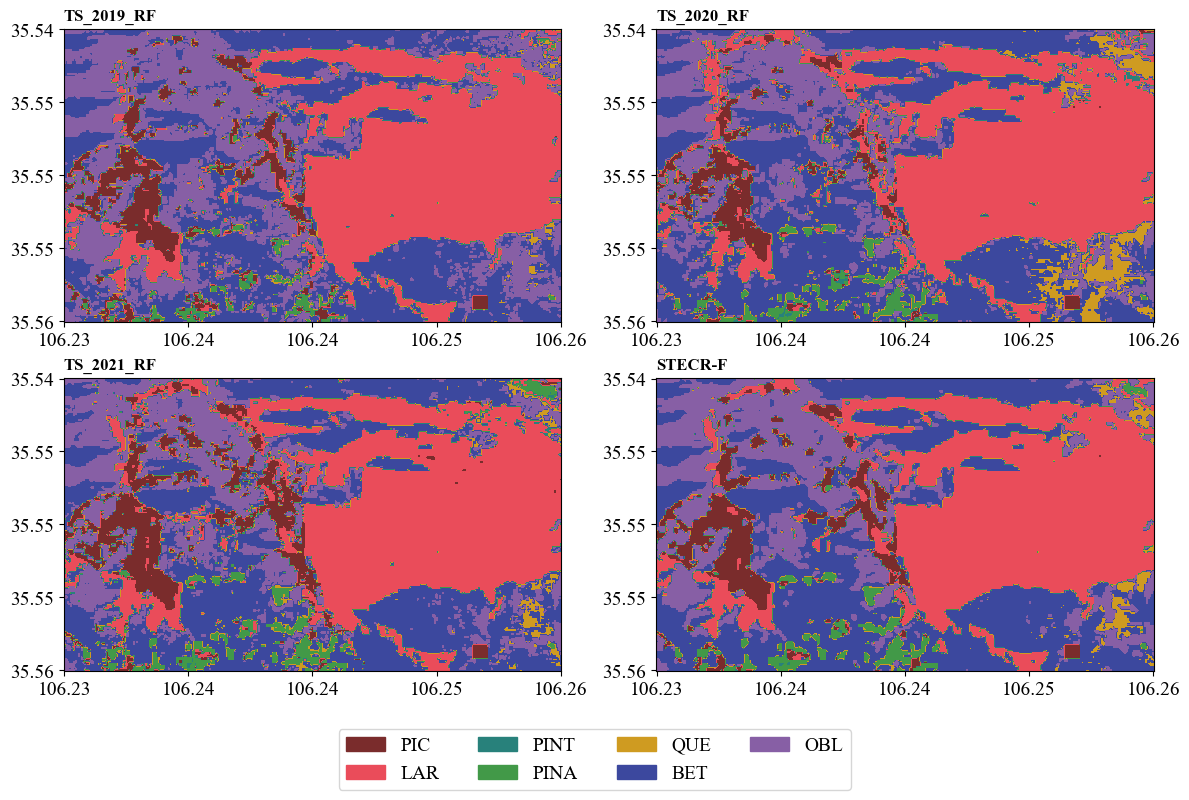

In [30]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import os

# Set global font to "Times New Roman"
plt.rcParams['font.family'] = 'Times New Roman'

# Get the absolute path of the current script's directory
base_path = os.path.abspath('')  # Get the absolute path of the current working directory

images_paths = [
    os.path.join(base_path, 'data', 'PITSCM', 'TS_2019_RF.tif'),
    os.path.join(base_path, 'data', 'PITSCM', 'TS_2020_RF.tif'),
    os.path.join(base_path, 'data', 'PITSCM', 'TS_2021_RF.tif'),
    os.path.join(base_path, 'data', 'STECR-F', 'STECR-F_0.25_19CEW1.0_COW0.3_20CEW1.0_COW0.3_21CEW1.0_COW0.3.tif')
]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 9))
axs = axs.flatten()  # Flatten the 2D array into a 1D array for easier indexing

# Define the color map and labels
colors = ['#FFFFFF','#7A2C2C','#EA4C5A', '#28817B', '#429948', '#CF9B21', '#3C489E', '#875FA5']
custom_labels = ['PIC', 'LAR', 'PINT', 'PINA', 'QUE', 'BET', 'OBL']
cmap = ListedColormap(colors)

# Display each image
for i, (image_path, xuhao) in enumerate(zip(images_paths, ['TS_2019_RF', 'TS_2020_RF', 'TS_2021_RF', 'STECR-F'])):
    
    # Open the image file
    with rasterio.open(image_path) as src:
        img_data = src.read(1)  # Read the first band
        
        # Mask pixels with value 15
        img_data = np.where(img_data == 15, -1, img_data)
        
        # Display the image
        axs[i].imshow(img_data, cmap=cmap, vmin=-1, vmax=6)
        
        # Set the title
        axs[i].set_title(f'{xuhao}', weight='bold', loc='left')
        axs[i].axis('on')  # Turn on axis

        # Add latitude and longitude ticks
        axs[i].set_xticks(np.linspace(0, img_data.shape[1] - 1, num=5))
        axs[i].set_yticks(np.linspace(0, img_data.shape[0] - 1, num=5))
        
        # Set x and y labels
        x_labels = np.round(np.linspace(src.bounds.left, src.bounds.right, num=5), 2)
        y_labels = np.round(np.linspace(src.bounds.bottom, src.bounds.top, num=5), 2)
        axs[i].set_xticklabels(x_labels, fontsize=14)
        axs[i].set_yticklabels(y_labels, fontsize=14)

# Add custom legend
legend_patches = [mpatches.Patch(color=colors[j+1], label=custom_labels[j]) for j in range(len(custom_labels))]
fig.legend(handles=legend_patches, loc='lower center', fontsize=14, ncol=4)

# Adjust layout
plt.subplots_adjust(bottom=-0.3)  # Increase bottom margin to make space for the legend
plt.tight_layout()
plt.show()
